# **Lab 6: Convolutional Neural Networks**
### Authors: Will Lahners, Edward Powers, and Nino Castellano

Our machine learning project presents a compelling business case, leveraging a comprehensive dataset comprising cars and motorcycles. The rationale behind this initiative is to cater to the pressing needs of law enforcement agencies, state departments of transportation, and similar entities, all of which rely heavily on efficient vehicle identification systems. By leveraging advanced algorithms, our software will empower police stations to expedite investigations, identify stolen vehicles, and enforce traffic regulations with greater precision. Similarly, state departments of transportation can streamline processes related to vehicle registration, licensing, and compliance, thereby reducing administrative burdens and enhancing overall operational efficiency. By offering a sophisticated solution tailored to the specific needs of these agencies, we not only create value for them but also contribute to the broader goal of promoting road safety and effective law enforcement practices. Hence, our machine learning project represents a strategic investment with far-reaching benefits for both public safety and administrative effectiveness.

## **Describing the Data**

Dataset: https://www.kaggle.com/datasets/utkarshsaxenadn/car-vs-bike-classification-dataset/data

## Preparation (3 points total)

In [2]:
import os
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import cv2
import numpy as np
import matplotlib.pyplot as plt  

data = {'path': [], 'label': []}

# Define the root path of our dataset
root_path = "Car-Bike-Dataset"

# Get the subfolders (Car and Bike)
folders = os.listdir(root_path)
for folder in folders:
    folder_path = os.path.join(root_path, folder)
    files = os.listdir(folder_path)
    for file in files:
        file_path = os.path.join(folder_path, file)
        data['path'].append(file_path)
        data['label'].append(folder)

# Create a Pandas DataFrame
df = pd.DataFrame(data)

# Encode labels using LabelEncoder (Car: 0, Bike: 1)
le = LabelEncoder()
df['class'] = le.fit_transform(df['label'])

# Shuffle the DataFrame
shuffled_df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Define image size for resizing
h, w = 100, 100

# Create a list to store resized and grayscaled images
table_data = []

# Iterate through each image
for i, row in shuffled_df.iterrows():
    img_path = row['path']
    img = cv2.imread(img_path)
    res_img = cv2.resize(img, dsize=(h, w))
    gray_img = cv2.cvtColor(res_img, cv2.COLOR_BGR2GRAY)
    gray_img_with_channel = np.expand_dims(gray_img, axis=-1)  
    table_data.append(gray_img_with_channel) 

# Convert the image data to a NumPy array
X = np.array(table_data)
y = shuffled_df['class']
labels = shuffled_df['label']

# Code credit to us

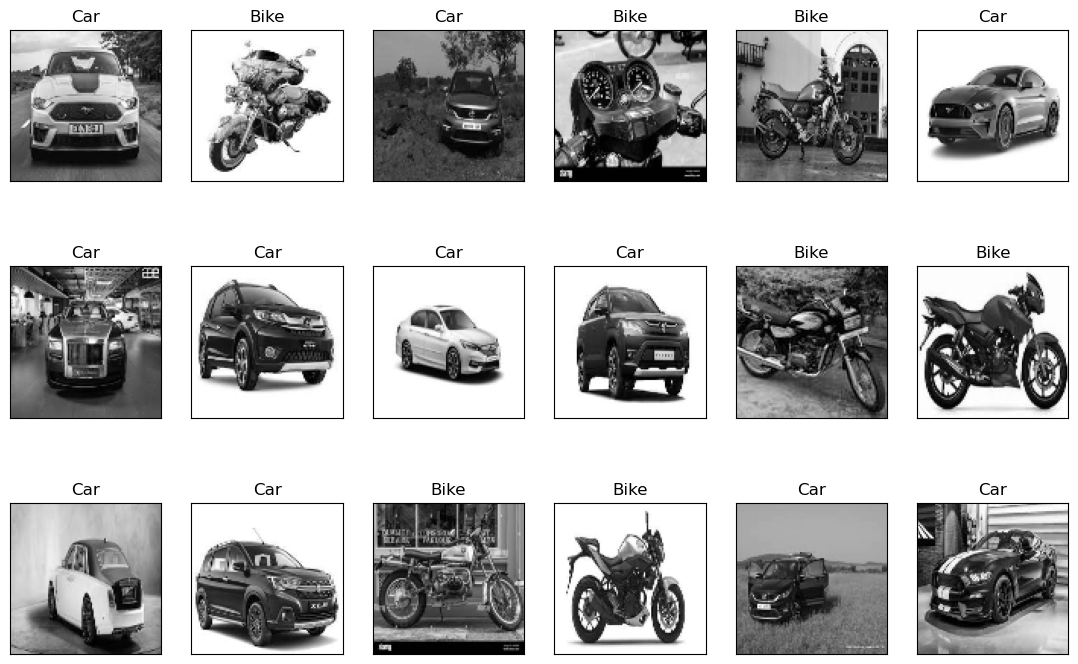

In [3]:
def plot_gallery(images, titles, h, w, n_row=3, n_col=6):
    """Helper function to plot a gallery of images"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

# Assuming labels is a list of 'Car' and 'Bike' labels
plot_gallery(X, labels, h, w)

# Code credit to us

> [1.5 points] Choose and explain what metric(s) you will use to evaluate your algorithm’s performance. You should give a detailed argument for why this (these) metric(s) are appropriate on your data. That is, why is the metric appropriate for the task (e.g., in terms of the business case for the task). Please note: rarely is accuracy the best evaluation metric to use. Think deeply about an appropriate measure of performance.

We will go with the **F1-Score** as our metric. 

In this scenario, both precision and recall are important:
Precision: We want to ensure that when the model identifies a vehicle as a car, it is indeed a car. Misclassifying a bike as a car could lead to incorrect traffic light timing or inaccurate traffic flow analysis.
Recall: We also want to ensure that the model correctly identifies most cars. Missing cars could lead to underestimation of traffic volume and congestion, impacting traffic management decisions.
The F1-score balances precision and recall, making it a suitable choice when both aspects are crucial. It provides a single score that reflects the overall accuracy and robustness of the model.

> [1.5 points] Choose the method you will use for dividing your data into training and testing (i.e., are you using Stratified 10-fold cross validation? Shuffle splits? Why?). Explain why your chosen method is appropriate or use more than one method as appropriate. Convince me that your cross validation method is a realistic mirroring of how an algorithm would be used in practice. 

A stratified K-fold cross-validation with K=10 offers a robust and realistic approach to evaluating the performance of our car vs. bike classification model. It ensures that the model is tested on diverse data, reflects the real-world scenario of encountering a continuous stream of images, and mitigates potential biases due to class imbalances.

In [4]:
from sklearn.model_selection import StratifiedKFold
import tensorflow as tf

# Define the number of folds and batch size
k = 10
batch_size = 128

# Create a StratifiedKFold object
skfold = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

# Lists to store the datasets for each fold
train_datasets = []
test_datasets = []

# Create datasets for each fold
for train_index, test_index in skfold.split(X, y):
    # Split data into training and testing sets
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Create TensorFlow datasets
    ds_train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    ds_train = ds_train.batch(batch_size).prefetch(batch_size)
    train_datasets.append(ds_train)

    ds_test = tf.data.Dataset.from_tensor_slices((X_test, y_test))
    ds_test = ds_test.batch(batch_size).prefetch(batch_size)
    test_datasets.append(ds_test)

# Code credit to Gemini API and us

2024-04-22 12:15:18.867246: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-22 12:15:20.193657: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


## Modeling (6 points total)



> [1.5 points]  Setup the training to use data expansion in Keras (also called data augmentation). Explain why the chosen data expansion techniques are appropriate for your dataset. You should make use of Keras augmentation layers, like in the class examples.

> [2 points] Create a convolutional neural network to use on your data using Keras. Investigate at least two different convolutional network architectures and investigate changing one or more parameters of each architecture such as the number of filters. This means, at a  minimum, you will train a total of four models (2 different architectures, with 2 parameters changed in each architecture). Use the method of train/test splitting and evaluation metric that you argued for at the beginning of the lab. Visualize the performance of the training and validation sets per iteration (use the "history" parameter of Keras). Be sure that models converge. 

**Architecture 1: Baseline CNN**

*Model 1A (Baseline):*
Convolutional Layers: 2 layers with 32 filters each, (3, 3) kernel size
Dense Layer: 128 units
Dropout: 0.5
*Model 1B (More Filters):*
Convolutional Layers: 2 layers with 64 filters each, (3, 3) kernel size
Dense Layer: 128 units
Dropout: 0.5

**Architecture 2: ResNet**

*Model 2A (Basic ResNet):*
Similar to the ResNet example provided in class, with 2 residual blocks.
Filters: 32 in the initial layers, 64 in the residual blocks.
Dense Layer: 256 units
Dropout: 0.25 before the dense layer, 0.5 before the output layer.
*Model 2B (Deeper ResNet):*
Add one more residual block to Model 2A, increasing the network depth.
Keep the filter sizes and dense layer configuration the same.
Dropout: 0.25 before each dense layer.

### **Model 1A:** (3, 3) kernel size, 32 filters each

In [5]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomContrast

# Define the model
model1a = Sequential()

# Data Augmentation Layers
model1a.add(RandomFlip("horizontal"))
model1a.add(RandomRotation(0.1))
model1a.add(RandomZoom(0.1))
model1a.add(RandomContrast(0.1))

# Convolutional Layers
model1a.add(Conv2D(32, (3, 3), activation="relu", input_shape=(h, w, 1))) 
model1a.add(MaxPooling2D((2, 2)))
model1a.add(Conv2D(64, (3, 3), activation="relu"))
model1a.add(MaxPooling2D((2, 2)))

# Classification Layers
model1a.add(Flatten())
model1a.add(Dense(128, activation="relu"))
model1a.add(Dropout(0.5))
model1a.add(Dense(1, activation="sigmoid"))  # Output layer

# Compile the model
model1a.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()])

# Code credit to Gemini API and us

In [6]:
# Lists to store metrics for each fold
model1a_fold_f1_scores = []
model1a_fold_histories = []

epochs = 10

# Iterate through the folds
for fold, (ds_train, ds_test) in enumerate(zip(train_datasets, test_datasets)):
    # Train the model
    print(f"Training for Fold {fold+1}")
    history = model1a.fit(ds_train, epochs=epochs, validation_data=ds_test, verbose=1)

    # Evaluate on the test set
    _, accuracy, precision, recall, auc = model1a.evaluate(ds_test, verbose=0)
    f1_score = 2 * (precision * recall) / (precision + recall)
    model1a_fold_f1_scores.append(f1_score)
    model1a_fold_histories.append(history)

# Code credit to Gemini API and us

Training for Fold 1
Epoch 1/10


2024-04-22 12:15:30.040685: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [3600]
	 [[{{node Placeholder/_1}}]]
2024-04-22 12:15:30.040867: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [3600]
	 [[{{node Placeholder/_1}}]]


29/29 [==============================] - ETA: 0s - loss: 64.8180 - accuracy: 0.5481 - precision: 0.5451 - recall: 0.5806 - auc: 0.5429

2024-04-22 12:15:50.085433: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [400]
	 [[{{node Placeholder/_1}}]]
2024-04-22 12:15:50.095701: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [400]
	 [[{{node Placeholder/_1}}]]


29/29 [==============================] - 21s 666ms/step - loss: 64.8180 - accuracy: 0.5481 - precision: 0.5451 - recall: 0.5806 - auc: 0.5429 - val_loss: 0.5736 - val_accuracy: 0.7325 - val_precision: 0.7385 - val_recall: 0.7200 - val_auc: 0.7966
Epoch 2/10
29/29 [==============================] - 17s 598ms/step - loss: 0.5817 - accuracy: 0.7256 - precision: 0.7391 - recall: 0.6972 - auc: 0.7873 - val_loss: 0.6481 - val_accuracy: 0.7225 - val_precision: 0.6654 - val_recall: 0.8950 - val_auc: 0.8586
Epoch 3/10
29/29 [==============================] - 18s 631ms/step - loss: 0.4731 - accuracy: 0.7944 - precision: 0.8022 - recall: 0.7817 - auc: 0.8703 - val_loss: 0.4678 - val_accuracy: 0.7975 - val_precision: 0.7554 - val_recall: 0.8800 - val_auc: 0.8987
Epoch 4/10
29/29 [==============================] - 17s 598ms/step - loss: 0.4162 - accuracy: 0.8131 - precision: 0.8263 - recall: 0.7928 - auc: 0.8941 - val_loss: 0.3665 - val_accuracy: 0.8600 - val_precision: 0.9286 - val_recall: 0.7800 

2024-04-22 12:19:01.795871: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [3600]
	 [[{{node Placeholder/_1}}]]
2024-04-22 12:19:01.796235: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [3600]
	 [[{{node Placeholder/_1}}]]


29/29 [==============================] - ETA: 0s - loss: 0.3038 - accuracy: 0.8686 - precision: 0.8763 - recall: 0.8583 - auc: 0.9446

2024-04-22 12:19:18.415623: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [400]
	 [[{{node Placeholder/_1}}]]
2024-04-22 12:19:18.416820: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [400]
	 [[{{node Placeholder/_1}}]]


29/29 [==============================] - 17s 600ms/step - loss: 0.3038 - accuracy: 0.8686 - precision: 0.8763 - recall: 0.8583 - auc: 0.9446 - val_loss: 0.3247 - val_accuracy: 0.8775 - val_precision: 0.9689 - val_recall: 0.7800 - val_auc: 0.9697
Epoch 2/10
29/29 [==============================] - 18s 633ms/step - loss: 0.2812 - accuracy: 0.8819 - precision: 0.8822 - recall: 0.8817 - auc: 0.9522 - val_loss: 0.2958 - val_accuracy: 0.8800 - val_precision: 0.9578 - val_recall: 0.7950 - val_auc: 0.9678
Epoch 3/10
29/29 [==============================] - 21s 731ms/step - loss: 0.2819 - accuracy: 0.8783 - precision: 0.8830 - recall: 0.8722 - auc: 0.9518 - val_loss: 0.2511 - val_accuracy: 0.9050 - val_precision: 0.9655 - val_recall: 0.8400 - val_auc: 0.9733
Epoch 4/10
29/29 [==============================] - 17s 600ms/step - loss: 0.2718 - accuracy: 0.8897 - precision: 0.8917 - recall: 0.8872 - auc: 0.9555 - val_loss: 0.4362 - val_accuracy: 0.8325 - val_precision: 0.9716 - val_recall: 0.6850 -

2024-04-22 12:21:57.738746: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [3600]
	 [[{{node Placeholder/_1}}]]
2024-04-22 12:21:57.740123: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [3600]
	 [[{{node Placeholder/_1}}]]


29/29 [==============================] - ETA: 0s - loss: 0.3116 - accuracy: 0.8650 - precision: 0.8662 - recall: 0.8633 - auc: 0.9415

2024-04-22 12:22:13.954079: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [400]
	 [[{{node Placeholder/_1}}]]
2024-04-22 12:22:13.955791: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [400]
	 [[{{node Placeholder/_1}}]]


29/29 [==============================] - 17s 577ms/step - loss: 0.3116 - accuracy: 0.8650 - precision: 0.8662 - recall: 0.8633 - auc: 0.9415 - val_loss: 0.3197 - val_accuracy: 0.8700 - val_precision: 0.9933 - val_recall: 0.7450 - val_auc: 0.9833
Epoch 2/10
29/29 [==============================] - 17s 579ms/step - loss: 0.2593 - accuracy: 0.8892 - precision: 0.8924 - recall: 0.8850 - auc: 0.9599 - val_loss: 0.2190 - val_accuracy: 0.9175 - val_precision: 0.9771 - val_recall: 0.8550 - val_auc: 0.9809
Epoch 3/10
29/29 [==============================] - 17s 582ms/step - loss: 0.2449 - accuracy: 0.9019 - precision: 0.9081 - recall: 0.8944 - auc: 0.9642 - val_loss: 0.2432 - val_accuracy: 0.9175 - val_precision: 0.9883 - val_recall: 0.8450 - val_auc: 0.9804
Epoch 4/10
29/29 [==============================] - 17s 580ms/step - loss: 0.2592 - accuracy: 0.9000 - precision: 0.9063 - recall: 0.8922 - auc: 0.9621 - val_loss: 0.2341 - val_accuracy: 0.9100 - val_precision: 0.9824 - val_recall: 0.8350 -

2024-04-22 12:25:00.086039: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [3600]
	 [[{{node Placeholder/_1}}]]
2024-04-22 12:25:00.086363: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [3600]
	 [[{{node Placeholder/_1}}]]


29/29 [==============================] - ETA: 0s - loss: 0.2442 - accuracy: 0.9050 - precision: 0.9128 - recall: 0.8956 - auc: 0.9650

2024-04-22 12:25:17.655276: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [400]
	 [[{{node Placeholder/_1}}]]
2024-04-22 12:25:17.657189: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [400]
	 [[{{node Placeholder/_1}}]]


29/29 [==============================] - 18s 635ms/step - loss: 0.2442 - accuracy: 0.9050 - precision: 0.9128 - recall: 0.8956 - auc: 0.9650 - val_loss: 0.2835 - val_accuracy: 0.8900 - val_precision: 0.9756 - val_recall: 0.8000 - val_auc: 0.9764
Epoch 2/10
29/29 [==============================] - 17s 603ms/step - loss: 0.2492 - accuracy: 0.9022 - precision: 0.9151 - recall: 0.8867 - auc: 0.9635 - val_loss: 0.2208 - val_accuracy: 0.9200 - val_precision: 0.9158 - val_recall: 0.9250 - val_auc: 0.9749
Epoch 3/10
29/29 [==============================] - 19s 647ms/step - loss: 0.2291 - accuracy: 0.9058 - precision: 0.9129 - recall: 0.8972 - auc: 0.9687 - val_loss: 0.2270 - val_accuracy: 0.9125 - val_precision: 0.9609 - val_recall: 0.8600 - val_auc: 0.9794
Epoch 4/10
29/29 [==============================] - 19s 661ms/step - loss: 0.2077 - accuracy: 0.9147 - precision: 0.9187 - recall: 0.9100 - auc: 0.9736 - val_loss: 0.2054 - val_accuracy: 0.9250 - val_precision: 0.9620 - val_recall: 0.8850 -

2024-04-22 12:28:18.191477: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [3600]
	 [[{{node Placeholder/_1}}]]
2024-04-22 12:28:18.191670: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [3600]
	 [[{{node Placeholder/_1}}]]


29/29 [==============================] - ETA: 0s - loss: 0.2038 - accuracy: 0.9181 - precision: 0.9220 - recall: 0.9133 - auc: 0.9754

2024-04-22 12:28:37.203032: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [400]
	 [[{{node Placeholder/_1}}]]
2024-04-22 12:28:37.204339: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [400]
	 [[{{node Placeholder/_1}}]]


29/29 [==============================] - 20s 680ms/step - loss: 0.2038 - accuracy: 0.9181 - precision: 0.9220 - recall: 0.9133 - auc: 0.9754 - val_loss: 0.1641 - val_accuracy: 0.9375 - val_precision: 0.9888 - val_recall: 0.8850 - val_auc: 0.9898
Epoch 2/10
29/29 [==============================] - 23s 785ms/step - loss: 0.1934 - accuracy: 0.9200 - precision: 0.9295 - recall: 0.9089 - auc: 0.9771 - val_loss: 0.1757 - val_accuracy: 0.9425 - val_precision: 0.9836 - val_recall: 0.9000 - val_auc: 0.9889
Epoch 3/10
29/29 [==============================] - 18s 625ms/step - loss: 0.1969 - accuracy: 0.9211 - precision: 0.9292 - recall: 0.9117 - auc: 0.9773 - val_loss: 0.1858 - val_accuracy: 0.9400 - val_precision: 0.9889 - val_recall: 0.8900 - val_auc: 0.9856
Epoch 4/10
29/29 [==============================] - 18s 610ms/step - loss: 0.1856 - accuracy: 0.9286 - precision: 0.9342 - recall: 0.9222 - auc: 0.9790 - val_loss: 0.1459 - val_accuracy: 0.9425 - val_precision: 0.9403 - val_recall: 0.9450 -

2024-04-22 12:31:30.216228: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [3600]
	 [[{{node Placeholder/_1}}]]
2024-04-22 12:31:30.216431: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [3600]
	 [[{{node Placeholder/_1}}]]


29/29 [==============================] - ETA: 0s - loss: 0.1819 - accuracy: 0.9306 - precision: 0.9369 - recall: 0.9233 - auc: 0.9801

2024-04-22 12:31:46.894633: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [400]
	 [[{{node Placeholder/_1}}]]
2024-04-22 12:31:46.895855: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [400]
	 [[{{node Placeholder/_1}}]]


29/29 [==============================] - 17s 605ms/step - loss: 0.1819 - accuracy: 0.9306 - precision: 0.9369 - recall: 0.9233 - auc: 0.9801 - val_loss: 0.2702 - val_accuracy: 0.9275 - val_precision: 0.9724 - val_recall: 0.8800 - val_auc: 0.9723
Epoch 2/10
29/29 [==============================] - 18s 639ms/step - loss: 0.1951 - accuracy: 0.9186 - precision: 0.9226 - recall: 0.9139 - auc: 0.9772 - val_loss: 0.2233 - val_accuracy: 0.9400 - val_precision: 0.9681 - val_recall: 0.9100 - val_auc: 0.9735
Epoch 3/10
29/29 [==============================] - 18s 626ms/step - loss: 0.1743 - accuracy: 0.9292 - precision: 0.9367 - recall: 0.9206 - auc: 0.9817 - val_loss: 0.2565 - val_accuracy: 0.9425 - val_precision: 0.9733 - val_recall: 0.9100 - val_auc: 0.9697
Epoch 4/10
29/29 [==============================] - 17s 581ms/step - loss: 0.1707 - accuracy: 0.9297 - precision: 0.9324 - recall: 0.9267 - auc: 0.9823 - val_loss: 0.2653 - val_accuracy: 0.9400 - val_precision: 0.9632 - val_recall: 0.9150 -

2024-04-22 12:34:26.419500: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [3600]
	 [[{{node Placeholder/_1}}]]
2024-04-22 12:34:26.420184: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [3600]
	 [[{{node Placeholder/_1}}]]


29/29 [==============================] - ETA: 0s - loss: 0.1771 - accuracy: 0.9286 - precision: 0.9356 - recall: 0.9206 - auc: 0.9810

2024-04-22 12:34:42.261679: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [400]
	 [[{{node Placeholder/_1}}]]
2024-04-22 12:34:42.268176: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [400]
	 [[{{node Placeholder/_1}}]]


29/29 [==============================] - 16s 569ms/step - loss: 0.1771 - accuracy: 0.9286 - precision: 0.9356 - recall: 0.9206 - auc: 0.9810 - val_loss: 0.1989 - val_accuracy: 0.9175 - val_precision: 0.9771 - val_recall: 0.8550 - val_auc: 0.9896
Epoch 2/10
29/29 [==============================] - 17s 582ms/step - loss: 0.1932 - accuracy: 0.9269 - precision: 0.9310 - recall: 0.9222 - auc: 0.9773 - val_loss: 0.5520 - val_accuracy: 0.8225 - val_precision: 0.9924 - val_recall: 0.6500 - val_auc: 0.9625
Epoch 3/10
29/29 [==============================] - 17s 581ms/step - loss: 0.1825 - accuracy: 0.9275 - precision: 0.9282 - recall: 0.9267 - auc: 0.9797 - val_loss: 0.1210 - val_accuracy: 0.9450 - val_precision: 0.9635 - val_recall: 0.9250 - val_auc: 0.9930
Epoch 4/10
29/29 [==============================] - 17s 591ms/step - loss: 0.1626 - accuracy: 0.9322 - precision: 0.9436 - recall: 0.9194 - auc: 0.9834 - val_loss: 0.1223 - val_accuracy: 0.9500 - val_precision: 0.9592 - val_recall: 0.9400 -

2024-04-22 12:37:20.428158: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [3600]
	 [[{{node Placeholder/_1}}]]
2024-04-22 12:37:20.429501: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [3600]
	 [[{{node Placeholder/_1}}]]


29/29 [==============================] - ETA: 0s - loss: 0.1835 - accuracy: 0.9253 - precision: 0.9327 - recall: 0.9167 - auc: 0.9796

2024-04-22 12:37:36.381233: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [400]
	 [[{{node Placeholder/_1}}]]
2024-04-22 12:37:36.387903: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [400]
	 [[{{node Placeholder/_1}}]]


29/29 [==============================] - 17s 577ms/step - loss: 0.1835 - accuracy: 0.9253 - precision: 0.9327 - recall: 0.9167 - auc: 0.9796 - val_loss: 0.1022 - val_accuracy: 0.9550 - val_precision: 0.9789 - val_recall: 0.9300 - val_auc: 0.9941
Epoch 2/10
29/29 [==============================] - 20s 679ms/step - loss: 0.1735 - accuracy: 0.9322 - precision: 0.9386 - recall: 0.9250 - auc: 0.9818 - val_loss: 0.1224 - val_accuracy: 0.9425 - val_precision: 0.9275 - val_recall: 0.9600 - val_auc: 0.9915
Epoch 3/10
29/29 [==============================] - 17s 598ms/step - loss: 0.1711 - accuracy: 0.9364 - precision: 0.9381 - recall: 0.9344 - auc: 0.9817 - val_loss: 0.1164 - val_accuracy: 0.9550 - val_precision: 0.9740 - val_recall: 0.9350 - val_auc: 0.9930
Epoch 4/10
29/29 [==============================] - 17s 591ms/step - loss: 0.1664 - accuracy: 0.9381 - precision: 0.9407 - recall: 0.9350 - auc: 0.9836 - val_loss: 0.1200 - val_accuracy: 0.9475 - val_precision: 0.9543 - val_recall: 0.9400 -

2024-04-22 12:40:19.398477: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [3600]
	 [[{{node Placeholder/_1}}]]
2024-04-22 12:40:19.398664: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [3600]
	 [[{{node Placeholder/_1}}]]


29/29 [==============================] - ETA: 0s - loss: 0.1622 - accuracy: 0.9358 - precision: 0.9400 - recall: 0.9311 - auc: 0.9840

2024-04-22 12:40:35.472770: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [400]
	 [[{{node Placeholder/_1}}]]
2024-04-22 12:40:35.473483: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [400]
	 [[{{node Placeholder/_1}}]]


29/29 [==============================] - 17s 580ms/step - loss: 0.1622 - accuracy: 0.9358 - precision: 0.9400 - recall: 0.9311 - auc: 0.9840 - val_loss: 0.0933 - val_accuracy: 0.9675 - val_precision: 0.9895 - val_recall: 0.9450 - val_auc: 0.9945
Epoch 2/10
29/29 [==============================] - 17s 579ms/step - loss: 0.1475 - accuracy: 0.9431 - precision: 0.9468 - recall: 0.9389 - auc: 0.9863 - val_loss: 0.0967 - val_accuracy: 0.9550 - val_precision: 0.9840 - val_recall: 0.9250 - val_auc: 0.9964
Epoch 3/10
29/29 [==============================] - 17s 578ms/step - loss: 0.1471 - accuracy: 0.9414 - precision: 0.9411 - recall: 0.9417 - auc: 0.9867 - val_loss: 0.0838 - val_accuracy: 0.9700 - val_precision: 0.9747 - val_recall: 0.9650 - val_auc: 0.9941
Epoch 4/10
29/29 [==============================] - 16s 569ms/step - loss: 0.1566 - accuracy: 0.9394 - precision: 0.9409 - recall: 0.9378 - auc: 0.9841 - val_loss: 0.1589 - val_accuracy: 0.9425 - val_precision: 0.9944 - val_recall: 0.8900 -

2024-04-22 12:43:18.449908: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [3600]
	 [[{{node Placeholder/_1}}]]
2024-04-22 12:43:18.450801: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [3600]
	 [[{{node Placeholder/_1}}]]


29/29 [==============================] - ETA: 0s - loss: 0.1474 - accuracy: 0.9425 - precision: 0.9457 - recall: 0.9389 - auc: 0.9864

2024-04-22 12:43:35.030044: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [400]
	 [[{{node Placeholder/_1}}]]
2024-04-22 12:43:35.037557: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [400]
	 [[{{node Placeholder/_1}}]]


29/29 [==============================] - 17s 592ms/step - loss: 0.1474 - accuracy: 0.9425 - precision: 0.9457 - recall: 0.9389 - auc: 0.9864 - val_loss: 0.1557 - val_accuracy: 0.9550 - val_precision: 1.0000 - val_recall: 0.9100 - val_auc: 0.9912
Epoch 2/10
29/29 [==============================] - 17s 575ms/step - loss: 0.1502 - accuracy: 0.9367 - precision: 0.9461 - recall: 0.9261 - auc: 0.9860 - val_loss: 0.1054 - val_accuracy: 0.9700 - val_precision: 0.9563 - val_recall: 0.9850 - val_auc: 0.9941
Epoch 3/10
29/29 [==============================] - 16s 563ms/step - loss: 0.1680 - accuracy: 0.9350 - precision: 0.9404 - recall: 0.9289 - auc: 0.9827 - val_loss: 0.1248 - val_accuracy: 0.9550 - val_precision: 0.9840 - val_recall: 0.9250 - val_auc: 0.9960
Epoch 4/10
29/29 [==============================] - 17s 585ms/step - loss: 0.1360 - accuracy: 0.9503 - precision: 0.9515 - recall: 0.9489 - auc: 0.9885 - val_loss: 0.1043 - val_accuracy: 0.9600 - val_precision: 0.9694 - val_recall: 0.9500 -

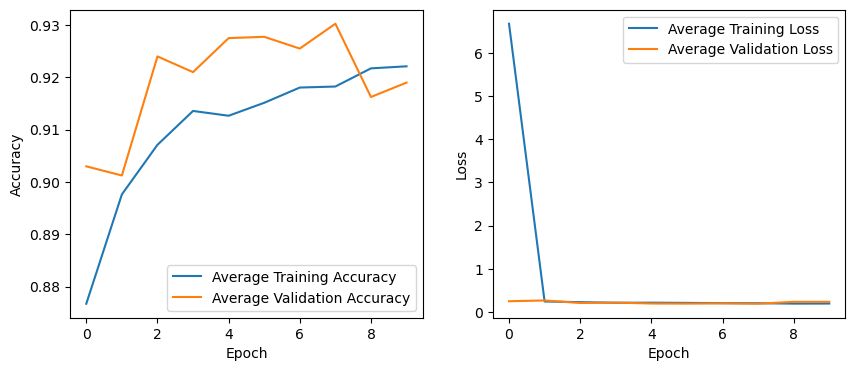

In [7]:
# Calculate average accuracy and loss across folds
avg_accuracy = np.mean([h.history['accuracy'] for h in model1a_fold_histories], axis=0)
avg_val_accuracy = np.mean([h.history['val_accuracy'] for h in model1a_fold_histories], axis=0)
avg_loss = np.mean([h.history['loss'] for h in model1a_fold_histories], axis=0)
avg_val_loss = np.mean([h.history['val_loss'] for h in model1a_fold_histories], axis=0)

# Plot the average curves
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(avg_accuracy, label='Average Training Accuracy')
plt.plot(avg_val_accuracy, label='Average Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(avg_loss, label='Average Training Loss')
plt.plot(avg_val_loss, label='Average Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Code credit to us

### **Model 1B:** (3, 3) kernel size, 64 filters each

In [9]:
# Define the model
model1b = Sequential()

# Data Augmentation Layers
model1b.add(RandomFlip("horizontal"))
model1b.add(RandomRotation(0.1))
model1b.add(RandomZoom(0.1))
model1b.add(RandomContrast(0.1))

# Convolutional Layers
model1b.add(Conv2D(64, (3, 3), activation="relu", input_shape=(h, w, 1))) # using 64 rather than 32 filters for this model
model1b.add(MaxPooling2D((2, 2)))
model1b.add(Conv2D(64, (3, 3), activation="relu")) 
model1b.add(MaxPooling2D((2, 2)))

# Classification Layers
model1b.add(Flatten())
model1b.add(Dense(128, activation="relu"))
model1b.add(Dropout(0.5))
model1b.add(Dense(1, activation="sigmoid"))  # Output layer

# Compile the model
model1b.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()])

# Code credit to Gemini API and us

Below took 234m 48.1s on 2070 SUPER

In [10]:
# Lists to store metrics for each fold
model1b_fold_f1_scores = []
model1b_fold_histories = []

# Iterate through the folds
for fold, (ds_train, ds_test) in enumerate(zip(train_datasets, test_datasets)):
    # Train the model
    print(f"Training for Fold {fold+1}")
    history = model1b.fit(ds_train, epochs=epochs, validation_data=ds_test, verbose=1)

    # Evaluate on the test set
    _, accuracy, precision, recall, auc = model1b.evaluate(ds_test, verbose=0)
    f1_score = 2 * (precision * recall) / (precision + recall)
    model1b_fold_f1_scores.append(f1_score)
    model1b_fold_histories.append(history)

# Code credit to Gemini API and us

Training for Fold 1
Epoch 1/10


29/29 [==============================] - 30s 986ms/step - loss: 38.2438 - accuracy: 0.5767 - precision_2: 0.5749 - recall_2: 0.5883 - auc_2: 0.5719 - val_loss: 0.6215 - val_accuracy: 0.7300 - val_precision_2: 0.7840 - val_recall_2: 0.6350 - val_auc_2: 0.7888
Epoch 2/10
29/29 [==============================] - 31s 1s/step - loss: 0.5657 - accuracy: 0.7331 - precision_2: 0.7463 - recall_2: 0.7061 - auc_2: 0.7945 - val_loss: 0.4078 - val_accuracy: 0.8425 - val_precision_2: 0.8914 - val_recall_2: 0.7800 - val_auc_2: 0.9096
Epoch 3/10
29/29 [==============================] - 28s 959ms/step - loss: 0.4672 - accuracy: 0.7931 - precision_2: 0.8044 - recall_2: 0.7744 - auc_2: 0.8668 - val_loss: 0.6047 - val_accuracy: 0.7875 - val_precision_2: 0.9675 - val_recall_2: 0.5950 - val_auc_2: 0.9375
Epoch 4/10
29/29 [==============================] - 27s 933ms/step - loss: 0.4205 - accuracy: 0.8194 - precision_2: 0.8414 - recall_2: 0.7872 - auc_2: 0.8956 - val_loss: 0.3864 - val_accuracy: 0.8400 - val_

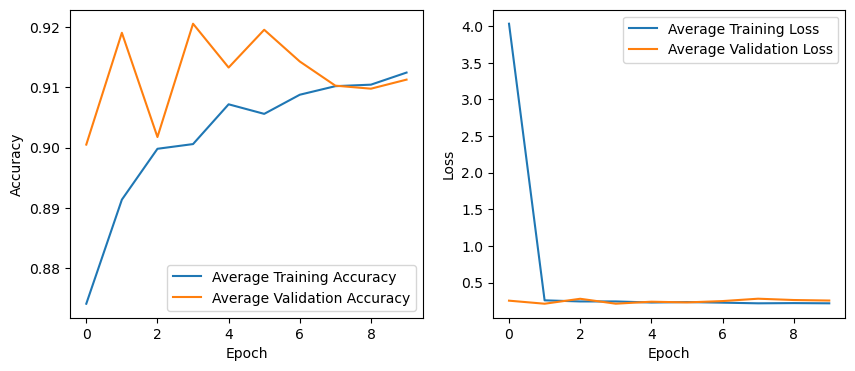

In [12]:
# Calculate average accuracy and loss across folds
avg_accuracy = np.mean([h.history['accuracy'] for h in model1b_fold_histories], axis=0)
avg_val_accuracy = np.mean([h.history['val_accuracy'] for h in model1b_fold_histories], axis=0)
avg_loss = np.mean([h.history['loss'] for h in model1b_fold_histories], axis=0)
avg_val_loss = np.mean([h.history['val_loss'] for h in model1b_fold_histories], axis=0)

# Plot the average curves
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(avg_accuracy, label='Average Training Accuracy')
plt.plot(avg_val_accuracy, label='Average Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(avg_loss, label='Average Training Loss')
plt.plot(avg_val_loss, label='Average Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Code credit to us

### **Model 2A:** ResNet with 2 residual blocks

In [13]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, Add, 
                                     Activation, Flatten, Dense, Dropout,
                                     RandomFlip, RandomRotation, RandomZoom, RandomContrast)

# Define input shape and hyperparameters
h, w, l = 100, 100, 1  # Image dimensions and channels (grayscale)
filters_initial = 32
filters_residual = 64

# Define the input layer
input_layer = Input(shape=(h, w, l))

# Data Augmentation
x = RandomFlip("horizontal")(input_layer)
x = RandomRotation(0.1)(x)
x = RandomZoom(0.1)(x)
x = RandomContrast(0.1)(x)

# Initial Convolutional Layer
x = Conv2D(filters_residual, (3, 3), padding="same", activation="relu")(x)  # Use 64 filters
x = MaxPooling2D((2, 2))(x)

# Residual Block 1
shortcut1 = x  # Save the input to the residual block
x = Conv2D(filters_residual, (3, 3), padding="same", activation="relu")(x)
x = Conv2D(filters_residual, (3, 3), padding="same")(x)
x = Add()([x, shortcut1])  # Add the residual connection
x = Activation("relu")(x)

# Residual Block 2
shortcut2 = x
x = Conv2D(filters_residual, (3, 3), padding="same", activation="relu")(x)
x = Conv2D(filters_residual, (3, 3), padding="same")(x)
x = Add()([x, shortcut2])
x = Activation("relu")(x)

# Classification Layers
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)
x = Dropout(0.25)(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
output_layer = Dense(1, activation="sigmoid")(x)

# Create the ResNet model
model2A = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model2A.compile(loss="binary_crossentropy", optimizer="adam", 
                 metrics=["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()])

# Code credit to Gemini API and us

Below took 238m 39.2s on 2070 SUPER

In [14]:
# Lists to store metrics for each fold
model2A_fold_f1_scores = []
model2A_fold_histories = []

# Number of epochs (adjust as needed)
epochs = 10 

# Iterate through the folds
for fold, (ds_train, ds_test) in enumerate(zip(train_datasets, test_datasets)):
    # Train the model
    print(f"Training for Fold {fold+1}")
    history = model2A.fit(ds_train, epochs=epochs, validation_data=ds_test, verbose=1)

    # Evaluate on the test set
    _, accuracy, precision, recall, auc = model2A.evaluate(ds_test, verbose=0)
    f1_score = 2 * (precision * recall) / (precision + recall)
    model2A_fold_f1_scores.append(f1_score)
    model2A_fold_histories.append(history)

# Code credit to Gemini API and us

Training for Fold 1
Epoch 1/10
29/29 [==============================] - 75s 3s/step - loss: 131.2646 - accuracy: 0.5064 - precision_3: 0.5074 - recall_3: 0.4400 - auc_3: 0.5025 - val_loss: 0.6888 - val_accuracy: 0.5050 - val_precision_3: 0.6250 - val_recall_3: 0.0250 - val_auc_3: 0.6065
Epoch 2/10
29/29 [==============================] - 72s 2s/step - loss: 0.6941 - accuracy: 0.4947 - precision_3: 0.4960 - recall_3: 0.6567 - auc_3: 0.5051 - val_loss: 0.6927 - val_accuracy: 0.4950 - val_precision_3: 0.4972 - val_recall_3: 0.8900 - val_auc_3: 0.5207
Epoch 3/10
29/29 [==============================] - 64s 2s/step - loss: 0.6924 - accuracy: 0.5067 - precision_3: 0.5056 - recall_3: 0.5994 - auc_3: 0.5250 - val_loss: 0.6892 - val_accuracy: 0.5050 - val_precision_3: 1.0000 - val_recall_3: 0.0100 - val_auc_3: 0.6255
Epoch 4/10
29/29 [==============================] - 82s 3s/step - loss: 0.6884 - accuracy: 0.5094 - precision_3: 0.5146 - recall_3: 0.3322 - auc_3: 0.5557 - val_loss: 0.6938 - val_

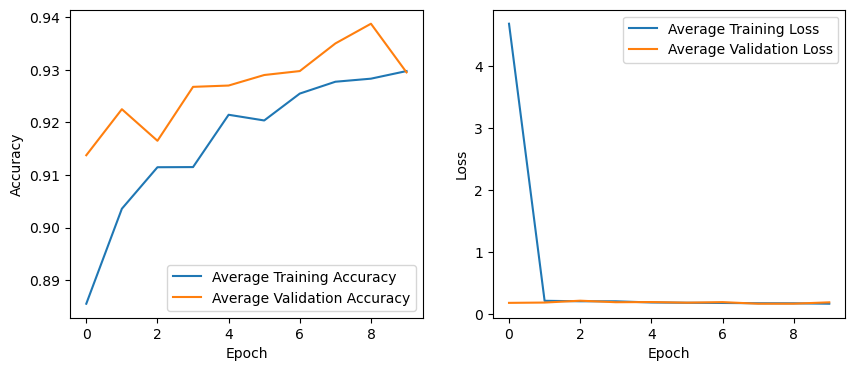

In [ ]:
# Calculate average accuracy and loss across folds
avg_accuracy = np.mean([h.history['accuracy'] for h in model2A_fold_histories], axis=0)
avg_val_accuracy = np.mean([h.history['val_accuracy'] for h in model2A_fold_histories], axis=0)
avg_loss = np.mean([h.history['loss'] for h in model2A_fold_histories], axis=0)
avg_val_loss = np.mean([h.history['val_loss'] for h in model2A_fold_histories], axis=0)

# Plot the average curves
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(avg_accuracy, label='Average Training Accuracy')
plt.plot(avg_val_accuracy, label='Average Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(avg_loss, label='Average Training Loss')
plt.plot(avg_val_loss, label='Average Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Code credit to us

### **Model 2B:** ResNet with 3 residual blocks

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, Add, 
                                     Activation, Flatten, Dense, Dropout,
                                     RandomFlip, RandomRotation, RandomZoom, RandomContrast)

# Define input shape and hyperparameters
h, w, l = 100, 100, 1  # Image dimensions and channels (grayscale)
filters_initial = 32
filters_residual = 64

# Define the input layer
input_layer = Input(shape=(h, w, l))

# Data Augmentation
x = RandomFlip("horizontal")(input_layer)
x = RandomRotation(0.1)(x)
x = RandomZoom(0.1)(x)
x = RandomContrast(0.1)(x)

# Initial Convolutional Layer
x = Conv2D(filters_residual, (3, 3), padding="same", activation="relu")(x)  # Use 64 filters
x = MaxPooling2D((2, 2))(x)

# Residual Block 1
shortcut1 = x  # Save the input to the residual block
x = Conv2D(filters_residual, (3, 3), padding="same", activation="relu")(x)
x = Conv2D(filters_residual, (3, 3), padding="same")(x)
x = Add()([x, shortcut1])  # Add the residual connection
x = Activation("relu")(x)

# Residual Block 2
shortcut2 = x
x = Conv2D(filters_residual, (3, 3), padding="same", activation="relu")(x)
x = Conv2D(filters_residual, (3, 3), padding="same")(x)
x = Add()([x, shortcut2])
x = Activation("relu")(x)

# *** Additional Residual Block 3 ***
shortcut3 = x
x = Conv2D(filters_residual, (3, 3), padding="same", activation="relu")(x)
x = Conv2D(filters_residual, (3, 3), padding="same")(x)
x = Add()([x, shortcut3])
x = Activation("relu")(x)

# Classification Layers (modified dropout)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)
x = Dropout(0.25)(x)  # Dropout before the first dense layer
x = Dense(256, activation="relu")(x)
x = Dropout(0.25)(x)  # Dropout before the output layer
output_layer = Dense(1, activation="sigmoid")(x)

# Create the ResNet model
model2B = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model2B.compile(loss="binary_crossentropy", optimizer="adam", 
                 metrics=["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()])

# Code credit to Gemini API and us

2024-04-22 11:59:14.648656: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-22 11:59:15.844505: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/will/miniconda3/envs/tf2/lib/:/home/will/miniconda3/envs/tf2/lib/
2024-04-22 11:59:15.844641: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/will/miniconda3/envs/tf2/lib/:/home/will/miniconda

In [ ]:
# Lists to store metrics for each fold
model2B_fold_f1_scores = []
model2B_fold_histories = []

# Number of epochs (adjust as needed)
epochs = 10 

# Iterate through the folds
for fold, (ds_train, ds_test) in enumerate(zip(train_datasets, test_datasets)):
    # Train the model
    print(f"Training for Fold {fold+1}")
    history = model2B.fit(ds_train, epochs=epochs, validation_data=ds_test, verbose=1)

    # Evaluate on the test set
    _, accuracy, precision, recall, auc = model2B.evaluate(ds_test, verbose=0)
    f1_score = 2 * (precision * recall) / (precision + recall)
    model2B_fold_f1_scores.append(f1_score)
    model2B_fold_histories.append(history)

# Code credit to Gemini API and us

In [ ]:
# Calculate average accuracy and loss across folds
avg_accuracy = np.mean([h.history['accuracy'] for h in model2B_fold_histories], axis=0)
avg_val_accuracy = np.mean([h.history['val_accuracy'] for h in model2B_fold_histories], axis=0)
avg_loss = np.mean([h.history['loss'] for h in model2B_fold_histories], axis=0)
avg_val_loss = np.mean([h.history['val_loss'] for h in model2B_fold_histories], axis=0)

# Plot the average curves
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(avg_accuracy, label='Average Training Accuracy')
plt.plot(avg_val_accuracy, label='Average Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(avg_loss, label='Average Training Loss')
plt.plot(avg_val_loss, label='Average Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Code credit to us

> [1.5 points] Visualize the final results of all the CNNs and interpret/compare the performances. Use proper statistics as appropriate, especially for comparing models. 

In [ ]:
import pandas as pd

data = {
    "Model 1A": model1A_fold_f1_scores,
    "Model 1B": model1B_fold_f1_scores,
    "Model 2A": model2A_fold_f1_scores,
    "Model 2B": model2B_fold_f1_scores
}
f1df = pd.DataFrame(data)

# Descriptive statistics
print(f1df.describe())

In [ ]:
# Paired t-test between Model 1A and Model 2B
from scipy import stats
t_statistic, p_value = stats.ttest_rel(f1df["Model 1A"], f1df["Model 2B"])
print(f"t-statistic: {t_statistic}, p-value: {p_value}")

In [ ]:
# Box plot
df.plot(kind="box", title="F1 Score Distribution")
plt.show()

# Bar plot with error bars
means = df.mean()
errors = df.std()
means.plot(kind="bar", yerr=errors, title="Mean F1 Scores with Standard Deviation")
plt.show()

> [1 points] Compare the performance of your convolutional network to a standard multi-layer perceptron (MLP) using the receiver operating characteristic and area under the curve. Use proper statistical comparison techniques.  

## Exceptional Work (1 points total)